# Training a Jet Tagging with **CNN 1D** 

---
In this notebook, we perform a Jet identification task using a multiclass classifier with a network based on Conv1D  layers.

The problem consists in identifying a given jet as a quark, a gluon, a W, a Z, or a top,
based on a jet sequence, i.e. a list of particles. Foe each particle, the four-momentum coordinates are given as features.
For details on the physics problem, see https://arxiv.org/pdf/1804.06913.pdf and https://arxiv.org/pdf/1908.05318.pdf.

For details on the dataset, see Notebook1

---

In [1]:
import os
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

# Preparation of the training and validation samples

---
In order to import the dataset, we now
- clone the dataset repository (to import the data in Colab)
- load the h5 files in the data/ repository
- extract the data we need: a target and jetImage 

To type shell commands, we start the command line with !

nb, if you are running locally you can skip the step below and change the paths later to point to the folder with your previous download of the datasets.

In [ ]:
! curl https://cernbox.cern.ch/index.php/s/xmTytsMPvCEA6Ar/download -o Data-MLtutorial.tar.gz
! tar -xvzf Data-MLtutorial.tar.gz 
! ls Data-MLtutorial/JetDataset/
! rm Data-MLtutorial.tar.gz 

In [3]:
inputDir = "Data-MLtutorial/JetDataset/"

In [4]:
target = np.array([])
jetList = np.array([])
# we cannot load all data on Colab. So we just take a few files
datafiles = ['%s/jetImage_7_100p_30000_40000.h5' %inputDir,
           '%s/jetImage_7_100p_60000_70000.h5' %inputDir,
            '%s/jetImage_7_100p_50000_60000.h5' %inputDir,
            '%s/jetImage_7_100p_10000_20000.h5' %inputDir,
            '%s/jetImage_7_100p_0_10000.h5' %inputDir]
# if you are running locallt, you can use the full dataset doing
# for fileIN in glob.glob("tutorials/HiggsSchool/data/*h5"):
for i, fileIN in enumerate(datafiles):
    f = h5py.File(fileIN)
    if i == 0: print(f.get("particleFeatureNames")[:])
    print("Appending %s" %fileIN)
    myJetList = np.array(f.get("jetConstituentList"))
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    jetList = np.concatenate([jetList, myJetList], axis=0) if jetList.size else myJetList
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    del myJetList, mytarget
    f.close()
print(target.shape, jetList.shape)

[b'j1_px' b'j1_py' b'j1_pz' b'j1_e' b'j1_erel' b'j1_pt' b'j1_ptrel'
 b'j1_eta' b'j1_etarel' b'j1_etarot' b'j1_phi' b'j1_phirel' b'j1_phirot'
 b'j1_deltaR' b'j1_costheta' b'j1_costhetarel' b'j1_pdgid']
Appending Data-MLtutorial/JetDataset//jetImage_7_100p_30000_40000.h5
Appending Data-MLtutorial/JetDataset//jetImage_7_100p_60000_70000.h5
Appending Data-MLtutorial/JetDataset//jetImage_7_100p_50000_60000.h5
Appending Data-MLtutorial/JetDataset//jetImage_7_100p_10000_20000.h5
Appending Data-MLtutorial/JetDataset//jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 100, 16)


The dataset consists of 50000 with up to 100 particles in each jet.  For each particle, 16 features are given (see printout)

---

We now shuffle the data, splitting them into a training and a validation dataset with 2:1 ratio

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(jetList, target, test_size=0.33)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
del jetList, target

(33500, 100, 16) (16500, 100, 16) (33500, 5) (16500, 5)


We interpret the last index (the particle feature) as the channel

# Building the Conv1D model

The model consists of a first step (technically a Conv2D, but practically a Conv1D) that takes the 16 per-particle features as input and create 10 outputs. This gives 10 chains of 100 elements, which are then processed by Conv1D filters.

In [6]:
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Conv1D, AveragePooling1D, Dropout, Flatten
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [7]:
featureArrayLength = (X_train.shape[1],X_train.shape[2])
dropoutRate = 0.25

In [8]:
####
inputList = Input(shape=(featureArrayLength))
x = Conv1D(20, kernel_size=3, data_format="channels_last", strides=1, padding="valid", activation='relu')(inputList)
x = AveragePooling1D(pool_size=3)(x)
#
x = Conv1D(40, kernel_size=3, data_format="channels_last", strides=1, padding="valid", activation='relu')(x)
x = AveragePooling1D(pool_size=3)(x)
#
x = Conv1D(60, kernel_size=2, data_format="channels_last", strides=1, padding="valid", activation='relu')(x)
x = AveragePooling1D(pool_size=9)(x)
#
x = Flatten()(x)
x = Dense(20, activation='relu')(x)
x = Dropout(dropoutRate)(x)
x = Dense(10, activation='relu')(x)
x = Dropout(dropoutRate)(x)
output = Dense(5, activation='softmax')(x)
####
model = Model(inputs=inputList, outputs=output)

2022-05-04 19:35:33.771860: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 16)]         0         
                                                                 
 conv1d (Conv1D)             (None, 98, 20)            980       
                                                                 
 average_pooling1d (AverageP  (None, 32, 20)           0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 30, 40)            2440      
                                                                 
 average_pooling1d_1 (Averag  (None, 10, 40)           0         
 ePooling1D)                                                     
                                                                 
 conv1d_2 (Conv1D)           (None, 9, 60)             4860  

We now train the model

In [10]:
batch_size = 128
n_epochs = 200

In [11]:
# train 
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Epoch 1/3
262/262 - 3s - loss: 1.5358 - val_loss: 1.4023 - lr: 0.0010 - 3s/epoch - 11ms/step
Epoch 2/3
262/262 - 2s - loss: 1.3931 - val_loss: 1.2959 - lr: 0.0010 - 2s/epoch - 8ms/step
Epoch 3/3
262/262 - 2s - loss: 1.3467 - val_loss: 1.2554 - lr: 0.0010 - 2s/epoch - 7ms/step


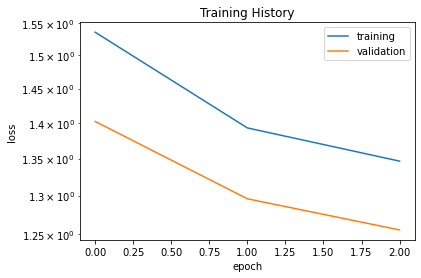

In [12]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Building the ROC Curves

In [13]:
labels = ['gluon', 'quark', 'W', 'Z', 'top']

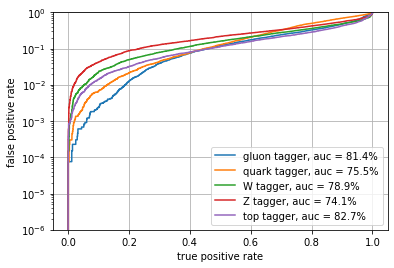

In [14]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
predict_val = model.predict(X_val)
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}

plt.figure()
for i, label in enumerate(labels):
        df[label] = y_val[:,i]
        df[label + '_pred'] = predict_val[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])

        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogy()
plt.xlabel("true positive rate")
plt.ylabel("false positive rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()